## **Classification of Protein Sequences via LSTMs and TCNs with Skip Connections**


Proteins are large, complex bio-molecules responsible for carrying out multiple critical bodily functions.  They are composed of chains (long variable-order sequences with repeats) of 20 possible amino acids.  The constituent amino acids that make up a protein determine its unique structure as well as function.  We will use deep learning and a protein database called 'Pfam' to classify amino acid sequences into their protein families.

In [ ]:
%matplotlib inline
!pip install einops
!pip install prettytable
!pip install python-Levenshtein==0.12.0

import gc
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import itertools
import random
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
from Levenshtein import distance as levenshtein_distance

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will n

In [ ]:
data_path = 'random_split' 
print('Available data', os.listdir(data_path))

def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)


df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')
df_train.head()

Available data ['random_split', 'test', 'train', 'dev']


,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,Penicillinase_R,Q81U16_BACAN/8-123,PF03965.16,ISEAELEIMKVLWLKSP.QTANEIIEE.LEDP.MDW..KPKTIRTL...,ISEAELEIMKVLWLKSPQTANEIIEELEDPMDWKPKTIRTLINRLV...
1,Rtt106,POB3_CANAL/362-454,PF08512.12,AGVPCSVKA...SEGYLFPL......DRCFLF.VTKPTLYIPYSE....,AGVPCSVKASEGYLFPLDRCFLFVTKPTLYIPYSEISSVVMSRTGG...
2,F-actin_cap_A,Q8I3I2_PLAF7/12-301,PF01267.17,IRHVLMNSPPGKLYDLVK..DINILL.G.........SSVSIQ.KI...,IRHVLMNSPPGKLYDLVKDINILLGSSVSIQKILEEVLKDYNEKNY...
3,HupF_HypC,O28902_ARCFU/1-65,PF01455.18,MCIAIPGR...I.ER..IDY...............P....IAIVDF...,MCIAIPGRIERIDYPIAIVDFKGLKKEVRIDLLENPQIGDYVLVHV...
4,DUF3794,R6BY75_9CLOT/189-271,PF12673.7,NIFHI..LWEDVDL..E.GVTFKPMG...E...........S.......,NIFHILWEDVDLEGVTFKPMGESISVQGDIHIFVLYEGEGENTPIR...


In [ ]:
print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  1086741
Val size:  126171
Test size:  126171


In [ ]:

def calc_unique_cls(train, test, val):
  """
  Prints # unique classes in data sets.
  """
  train_unq = np.unique(train['family_accession'].values)
  val_unq = np.unique(val['family_accession'].values)
  test_unq = np.unique(test['family_accession'].values)

  print('Number of unique classes in Train: ', len(train_unq))
  print('Number of unique classes in Val: ', len(val_unq))
  print('Number of unique classes in Test: ', len(test_unq))


calc_unique_cls(df_train, df_test, df_val)

Number of unique classes in Train:  17929
Number of unique classes in Val:  13071
Number of unique classes in Test:  13071


/var/folders/bm/t8hxv1ms6s30y8czfw0pmfk00000gn/T/ipykernel_7272/1115491351.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['seq_char_count'].values)
/var/folders/bm/t8hxv1ms6s30y8czfw0pmfk00000gn/T/ipykernel_7272/1115491351.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['seq_char_

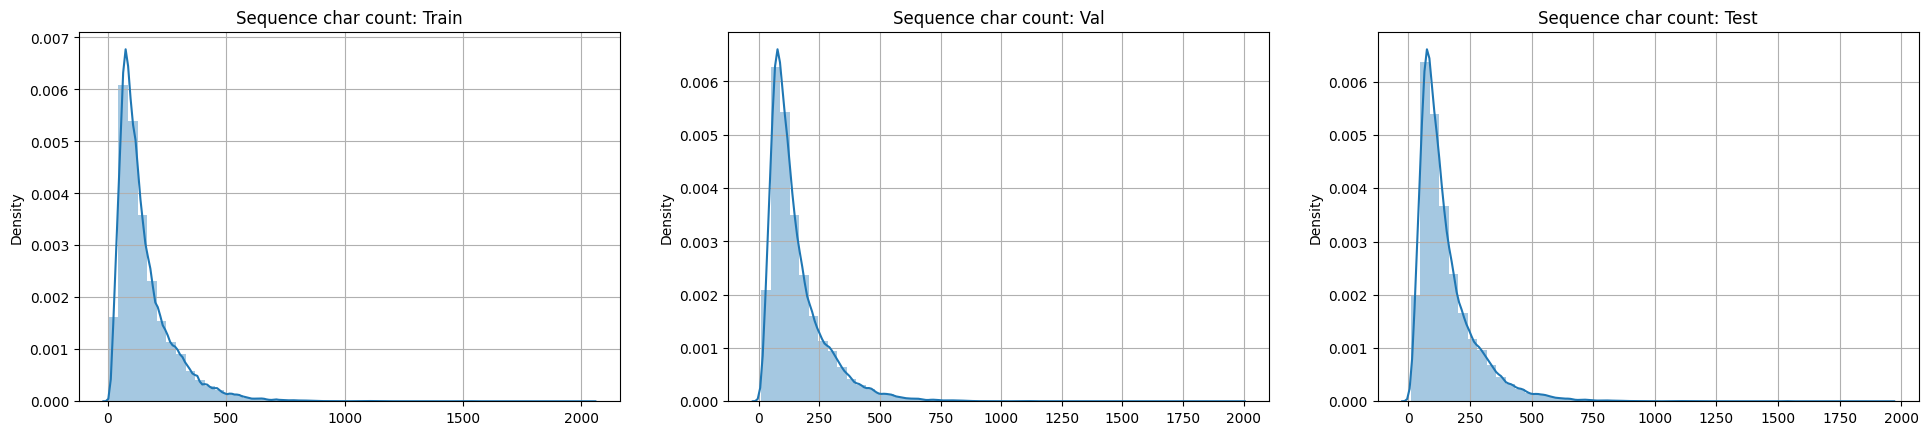

In [ ]:
df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)


plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()


In [ ]:
def get_code_freq(df, data_name):

  df = df.apply(lambda x: " ".join(x))

  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space

  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

# train code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')

# val code sequence
val_code_freq = get_code_freq(df_val['sequence'], 'Val')

# test code sequence
test_code_freq = get_code_freq(df_test['sequence'], 'Test')

def plot_code_freq(df, data_name):

  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

Codes: Train
Total unique codes: 25
Codes: Val
Total unique codes: 22
Codes: Test
Total unique codes: 24


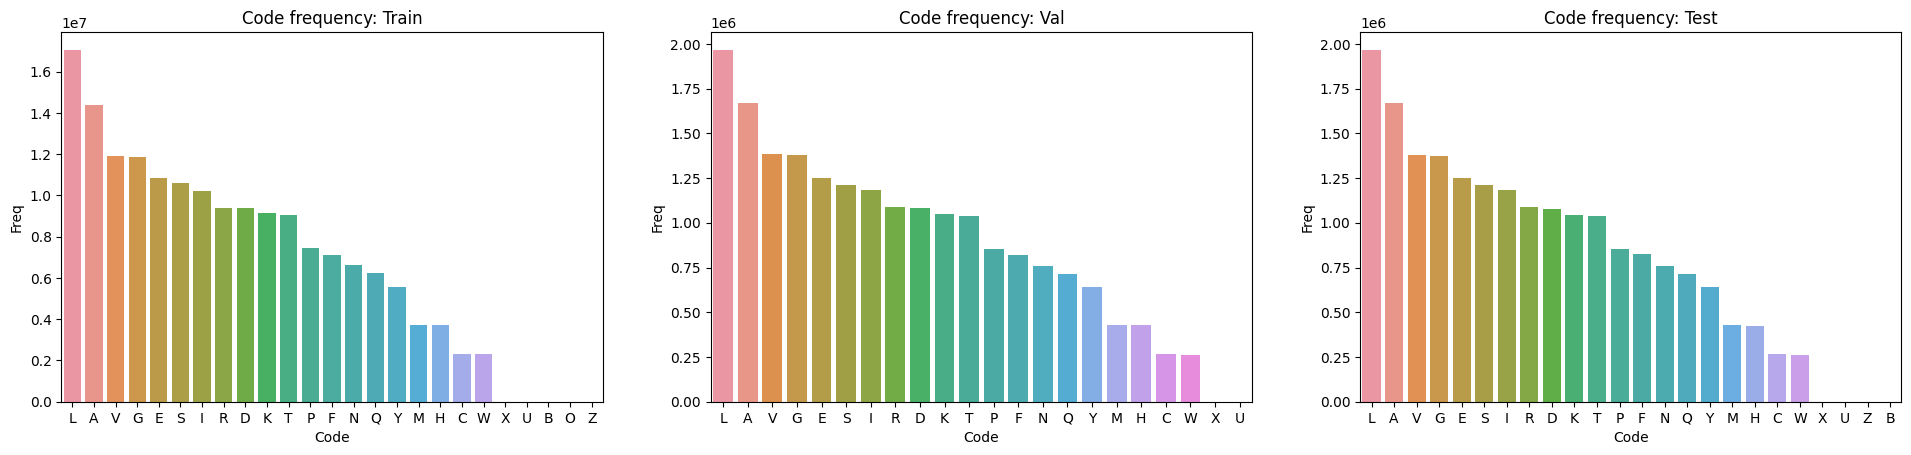

In [ ]:
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [ ]:
classes = df_train['family_accession'].value_counts()[:300].index.tolist()
len(classes)

# Filtering data based on considered 300 classes.
train_sm = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()

print('Data size after considering 300 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

# No. of unique classes after reducing the data size.

calc_unique_cls(train_sm, test_sm, val_sm)

Data size after considering 300 classes for each data split:
Train size : 210358
Val size : 26129
Test size : 26129
Number of unique classes in Train:  300
Number of unique classes in Val:  300
Number of unique classes in Test:  300


In [ ]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [ ]:
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids (and X 'wild-card') are taken into consideration.
    Remaining 4 uncommon amino acids are categorized as 0 (so not included).
  """

  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))

  return encode_list

train_encode = integer_encoding(train_sm)
val_encode = integer_encoding(val_sm)
test_encode = integer_encoding(test_sm)

#Just to visualize an example of the output
print(train_encode[0])

[11 16 18  9  5  4  4 17  1 17 12  4  6 18 10  7  5 17 18 16  9  4  3  1
 14  9  1 10  9 14  1 20 12 15 18  9  6  9 18 12  8 13  6  5 15  9  6  9
 18 16 20 13 18  5 18  9 11  8  6  4  4  1 10 20  4  3  1 10 12 20  1 10
 13 14  1 20  1 12  1 18  9  4  1  3 10  3 18 18  6 14 13  9  5  3 18  4
  9 11  7  9  6  6 16 19  4 10  9  1  4 18  1 17  9 13 16 18 16 10  6  3
 20  9  3 10 17 18  3  9 14  3 15  4 18 17  3  4  3 18  4 12 15 10  9 14
  1]


In [ ]:
# Encode labels/output variable y (amino acid family/class) into integers
le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((210358,), (26129,), (26129,))

In [ ]:
# Padding sequences

# Determine max_length

avg_train = (df_train['seq_char_count'].values).mean()
avg_test = (df_test['seq_char_count'].values).mean()
avg_val = (df_val['seq_char_count'].values).mean()

max_length = round((avg_train+avg_test+avg_val)/3 )
print('We use a maximum length of ',max_length)

# Pad the sequences

train_padded = pad_sequences(
    train_encode,
    maxlen=max_length,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0.0
)

test_padded = pad_sequences(
    test_encode,
    maxlen=max_length,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0.0
)

val_padded = pad_sequences(
    val_encode,
    maxlen=max_length,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0.0
)

# View new sizes
print('Size of train set: ', train_padded.shape,', size of validation set: ', val_padded.shape,', size of test set: ',test_padded.shape)

We use a maximum length of  155
Size of train set:  (210358, 155) , size of validation set:  (26129, 155) , size of test set:  (26129, 155)


In [ ]:
# One hot encoding of sequences
from tensorflow import keras

train_onehot = keras.utils.to_categorical(train_padded)
val_onehot = keras.utils.to_categorical(val_padded)
test_onehot = keras.utils.to_categorical(test_padded)

In [ ]:
print('Size of train set: ', train_onehot.shape,', size of validation set: ', val_onehot.shape,', size of test set: ',test_onehot.shape)


Size of train set:  (210358, 155, 21) , size of validation set:  (26129, 155, 21) , size of test set:  (26129, 155, 21)


In [ ]:
# One hot encoding of outputs
y_train_onehot = keras.utils.to_categorical(y_train_le)
y_val_onehot = keras.utils.to_categorical(y_val_le)
y_test_onehot = keras.utils.to_categorical(y_test_le)

In [ ]:
print('Size of output train set: ', y_train_onehot.shape,', size of output validation set: ', y_val_onehot.shape,', size of output test set: ',y_test_onehot.shape)


Size of output train set:  (210358, 300) , size of output validation set:  (26129, 300) , size of output test set:  (26129, 300)


In [ ]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()



def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)

  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

In [ ]:
from keras.layers import LSTM

inputs = Input(shape=(max_length,))
emb = Embedding(21, 128, input_length=max_length)(inputs)
bidirectional1 = Bidirectional(LSTM(128,  return_sequences = True))(emb)
bidirectional = Bidirectional(LSTM((128)))(bidirectional1)
dropout = Dropout(0.2)(bidirectional)
output = Dense(300, activation='softmax')(dropout)
model1 = Model(inputs = inputs, outputs=output)
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 155)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 155, 128)          2688      
                                                                 
 bidirectional_7 (Bidirecti  (None, 155, 256)          263168    
 onal)                                                           
                                                                 
 bidirectional_8 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               7710

In [ ]:
# Train using Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history1 = model1.fit(train_padded, y_train_onehot, validation_data=(val_padded, y_val_onehot), epochs=15, callbacks=[es],batch_size = 256)


Epoch 1/15
822/822 [==============================] - 67s 81ms/step - loss: 2.6050 - accuracy: 0.3771 - val_loss: 1.0644 - val_accuracy: 0.7416
Epoch 2/15
822/822 [==============================] - 67s 81ms/step - loss: 0.6948 - accuracy: 0.8283 - val_loss: 0.3671 - val_accuracy: 0.9119
Epoch 3/15
822/822 [==============================] - 66s 80ms/step - loss: 0.2930 - accuracy: 0.9284 - val_loss: 0.1772 - val_accuracy: 0.9562
Epoch 4/15
822/822 [==============================] - 67s 81ms/step - loss: 0.1583 - accuracy: 0.9615 - val_loss: 0.1077 - val_accuracy: 0.9741
Epoch 5/15
822/822 [==============================] - 70s 85ms/step - loss: 0.0969 - accuracy: 0.9765 - val_loss: 0.0757 - val_accuracy: 0.9808
Epoch 6/15
822/822 [==============================] - 68s 82ms/step - loss: 0.0656 - accuracy: 0.9842 - val_loss: 0.0549 - val_accuracy: 0.9863
Epoch 7/15
822/822 [==============================] - 71s 86ms/step - loss: 0.0477 - accuracy: 0.9888 - val_loss: 0.0514 - val_accuracy:

822/822 [==============================] - 25s 31ms/step - loss: 0.0038 - accuracy: 0.9993
Train loss:  0.003762276144698262
Train accuracy:  0.9993487000465393
----------------------------------------------------------------------
103/103 [==============================] - 3s 31ms/step - loss: 0.0210 - accuracy: 0.9945
Val loss:  0.020968284457921982
Val accuracy:  0.9944888949394226
----------------------------------------------------------------------
103/103 [==============================] - 3s 31ms/step - loss: 0.0231 - accuracy: 0.9938
Test loss:  0.023072367534041405
Test accuracy:  0.9937617182731628


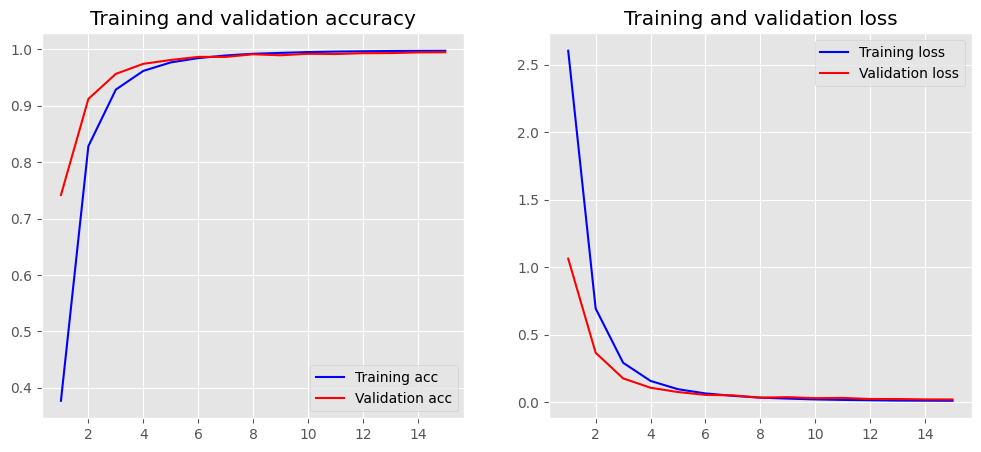

In [ ]:
display_model_score(model1,
    [train_padded, y_train_onehot],
    [val_padded, y_val_onehot],
    [test_padded, y_test_onehot],
    256)

plot_history(history1)

In [ ]:
embedding_weights =  model1.get_layer('embedding_4').get_weights() # Your code here to save your model weights
embedding_weights = np.array(embedding_weights)
embedding_weights = embedding_weights.reshape(21,128)
embedding_weights.shape

(21, 128)

In [ ]:
from einops import rearrange
num_classes = 5 # number of classes we will store average distances for

X = None
y = None
for class_of_interest in classes[:num_classes]:
  # e.g. class_of_interest == 'PF01967.21'
  class_indices = list(val_sm.loc[val_sm.family_accession==class_of_interest].index)

  # Your code here for storing the forward pass from the val_ohe samples that match your class_of_interest.
  all_class_samples = np.dot(val_onehot[class_indices],embedding_weights)

  # this rearranges to samples x features shape by flattening time and embedding shapes
  all_class_samples = rearrange(all_class_samples,'s t e -> s (t e)')
  if X is None:
    X = all_class_samples
    y = np.array([class_of_interest] * len(class_indices))
  else:
    X = np.concatenate((X, all_class_samples))
    y = np.concatenate((y, np.array([class_of_interest] * len(class_indices))))

print('The shape of our matrix X storring the embeddings is',X.shape)

The shape of our matrix X storring the embeddings is (1295, 19840)


In [ ]:
from sklearn.manifold import TSNE
# Your t-SNE code here
tsne = TSNE(n_components=2, random_state=0, perplexity=40.0)
tsne_results = tsne.fit_transform(X)

<Axes: xlabel='tsne-dim1', ylabel='tsne-dim2'>

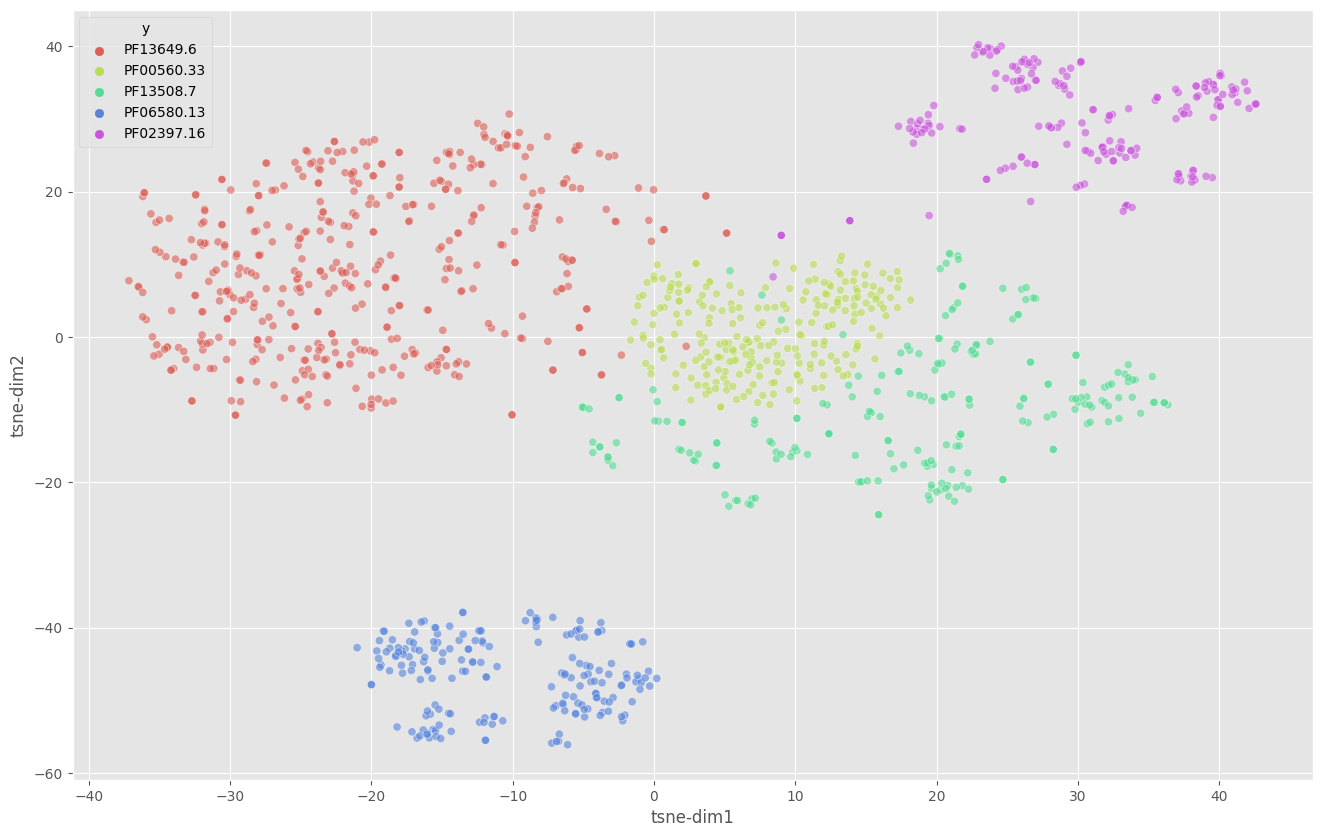

In [ ]:
import seaborn as sns

# this should plot your lower-dimensional representations of samples, colored by family_accession
tsne_df = pd.DataFrame()
tsne_df['y'] = y
tsne_df['tsne-dim1'] = tsne_results[:,0]
tsne_df['tsne-dim2'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-dim1", y="tsne-dim2",
    hue="y",
    palette=sns.color_palette("hls", num_classes),
    data=tsne_df,
    legend="full",
    alpha=0.6
)

The proteine sequence classification is generally seperated in different clusters, even on a reduced space such as a 2D map using nonlinear dimensionality reduction. Some proteins, such as PF06580.13 or PF02397.16 are highly separable, but PF00560.33 and PF13508.7 are slightly more mixed as the amino acids are more similar to one another.
The separation of TSNE into distinctable clusters indicate that the bidirectionnal LTSM successfully classified each protein into its respective family. This result is coherent with the obtained train accuracy of 99.9%, validation accuracy of 99.4% and test accuracy of 99.3% after only 15 epochs.

In [ ]:
import gc

try:
  del tsne_results
  del tsne_df
  del embeddings
  del model1
  del df_train
  del df_val
  del df_test
  del train_encode
  del val_encode
  del test_encode
  del y_train_le
  del y_val_le
  del y_test_le
  del train_pad
  del val_pad
  del test_pad
  gc.collect()
except:
  pass

In [ ]:
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """
  from keras.layers import LSTM

  x = data

  # 1st convulational layer
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate)(x)
  conv1 = Activation('relu')(conv1)

  # 2nd convulational layer
  conv2 = Conv1D(filters, 1, dilation_rate=d_rate)(conv1)
  conv2 = Activation('relu')(conv2)

  # Add F(x) + x
  added_output = Add()([data, conv2])

  # Relu Activation
  x = Activation('relu')(added_output)

  return x

In [ ]:

#input
input = Input(shape=(max_length,21))

#initial conv

conv = Conv1D(64, 1, padding='same')(input)

# per-residue representation
res1 = residual_block(conv, 64, 2)
res2 = residual_block(res1, 64, 3)

#Max Pooling
maxpool = MaxPooling1D(pool_size=2, strides=None, padding="same")(res2)

#Dropout
dropout = Dropout(0.2)(maxpool)

#Flatten
flat = Flatten()(dropout)

#softmax classifier
output_layer = Dense(300, activation='softmax')(flat)

#Compile your model
model2 = Model(inputs = input, outputs = output_layer)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 155, 21)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 155, 64)              1408      ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 155, 64)              4160      ['conv1d[0][0]']              
                                                                                                  
 activation (Activation)     (None, 155, 64)              0         ['conv1d_1[0][0]']            
                                                                                              

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history2 = model2.fit(train_onehot, y_train_onehot, validation_data=(val_onehot, y_val_onehot), epochs=10, callbacks=[es],batch_size = 256)


Epoch 1/10
822/822 [==============================] - 64s 78ms/step - loss: 0.3805 - accuracy: 0.9248 - val_loss: 0.0441 - val_accuracy: 0.9889
Epoch 2/10
822/822 [==============================] - 66s 80ms/step - loss: 0.0154 - accuracy: 0.9959 - val_loss: 0.0484 - val_accuracy: 0.9892
Epoch 3/10
822/822 [==============================] - 63s 77ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.0470 - val_accuracy: 0.9900
Epoch 4/10
822/822 [==============================] - 65s 79ms/step - loss: 0.0086 - accuracy: 0.9974 - val_loss: 0.0579 - val_accuracy: 0.9884
Epoch 4: early stopping


822/822 [==============================] - 23s 27ms/step - loss: 0.0048 - accuracy: 0.9985
Train loss:  0.004836509469896555
Train accuracy:  0.9985358119010925
----------------------------------------------------------------------
103/103 [==============================] - 3s 27ms/step - loss: 0.0579 - accuracy: 0.9884
Val loss:  0.057864852249622345
Val accuracy:  0.9884419441223145
----------------------------------------------------------------------
103/103 [==============================] - 3s 28ms/step - loss: 0.0512 - accuracy: 0.9894
Test loss:  0.05122875049710274
Test accuracy:  0.9894370436668396


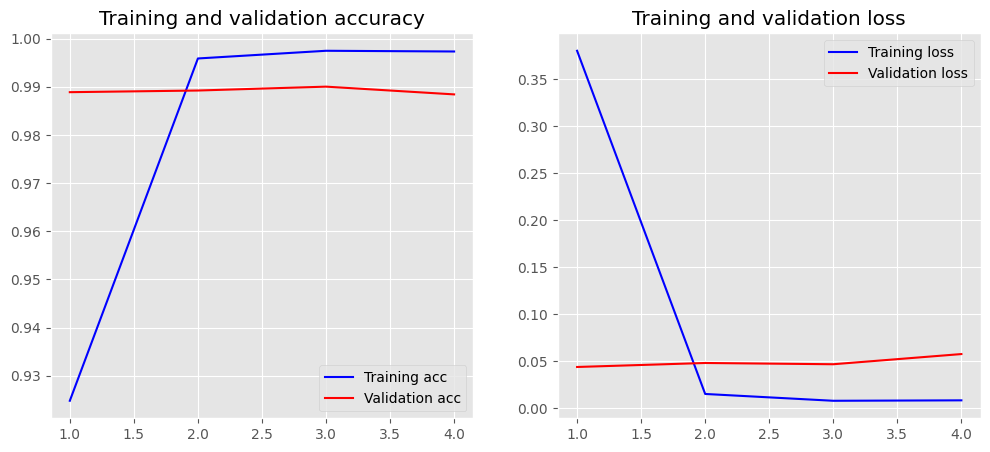

In [ ]:
plot_history(history2)
display_model_score(
    model2,
    [train_onehot, y_train_onehot],
    [val_onehot, y_val_onehot],
    [test_onehot, y_test_onehot],
    256)

The accuracies of each model were the following:


>   Training:
* 0.9993487000465393 for the Bidirectional LTSM
* 0.9985358119010925 for the ResNet


> Validation
* 0.9944888949394226 for the Bidirectional LTSM
* 0.9884419441223145 for the ResNet

> Test accuracy:  
* 0.9937617182731628 for the Bidirectional LTSM
* 0.9894370436668396 for the ResNet

However, this was after 15 epochs for the Bidirectional LTSM, compared to only 4 epochs due to early stopping for the ResNet. The ResNet performs a lot better for the amino acid classification, although we reduced the dimensionality from 128 to 64 for faster computation. The ResNet is also more time efficient, as it took only 4 minutes to achieve similar results, compared to about 20 minutes for the Bidirectional LTSM. The second ResNet model works better as it avoids overfitting. It solves the vanishing gradient problem that can happen in LTSM by using skip-connections.
